In [2]:
import pandas as pd

naslib_path = '../../zero_cost/NASLib'
benchmark = 'zc_nasbench201'

In [3]:
from zc_combine.utils.naslib_utils import load_search_space, parse_scores

search_space = load_search_space(naslib_path, benchmark)
dfs = parse_scores(search_space)

In [4]:
dataset = 'ImageNet16-120'
data = dfs[dataset]

In [5]:
import json
with open('meta.json', 'r') as f:
    meta = json.load(f)
nb201_unique = [v['nb201-string'] for k, v in meta['ids'].items() if k == v['isomorph']]
nb201_unique[0]

'|avg_pool_3x3~0|+|nor_conv_1x1~0|skip_connect~1|+|nor_conv_1x1~0|skip_connect~1|skip_connect~2|'

In [6]:
from zc_combine.features.conversions import keep_only_isomorpic_nb201

data = keep_only_isomorpic_nb201(data, meta)

In [7]:
from zc_combine.fixes.operations import get_ops_edges_nb201
from zc_combine.fixes.utils import nb201_zero_out_unreachable

_, edge_map = get_ops_edges_nb201()
nb201_zero_out_unreachable(data, edge_map)

In [8]:
print(len(data))
data = data[data['net'] == data['new_net']]
print(len(data))

6466
6144


In [9]:
from zc_combine.features.conversions import nb201_to_graph

nets = {i: nb201_to_graph(data.loc[i]) for i in data.index}

In [10]:
import json

with open('../zc_combine/configs/nb201_first.json', 'r') as f:
    cfg = json.load(f)

In [11]:
from zc_combine.features.nasbench201 import feature_func_dict
from zc_combine.features.dataset import get_feature_dataset

feature_dataset = get_feature_dataset(nets, cfg, feature_func_dict)
feature_dataset.keys()

dict_keys(['op_count', 'op_on_position', 'min_path_len', 'max_op_on_path', 'node_degree'])

In [12]:
features = ['op_count', 'min_path_len', 'max_op_on_path', 'node_degree']
dataset = pd.concat([feature_dataset[f] for f in features], axis=1)
dataset['val_accs'] = data['val_accs']
dataset

,op_count_0,op_count_1,op_count_2,op_count_3,op_count_4,min_path_len_banned_[1],"min_path_len_banned_[0, 1]","min_path_len_banned_[0, 1, 4]","min_path_len_banned_[1, 4]",max_op_on_path_allowed_[0],...,"node_degree_allowed_[0, 2]_avg_out","node_degree_allowed_[0, 3]_in_degree","node_degree_allowed_[0, 3]_out_degree","node_degree_allowed_[0, 3]_avg_in","node_degree_allowed_[0, 3]_avg_out","node_degree_allowed_[0, 2, 3]_in_degree","node_degree_allowed_[0, 2, 3]_out_degree","node_degree_allowed_[0, 2, 3]_avg_in","node_degree_allowed_[0, 2, 3]_avg_out",val_accs
idx,,,,,,,,,,,,,,,,,,,,,
0,1,1,0,2,2,1,1,1,1,2,...,0.25,2,2,0.75,0.75,2,2,0.75,0.75,32.700000
1,2,0,2,1,1,1,2,2,1,2,...,1.00,1,2,0.75,0.75,2,3,1.25,1.25,44.233333
3,2,1,2,1,0,1,1,1,1,2,...,1.00,2,1,0.75,0.75,3,3,1.25,1.25,40.600000
7,0,1,0,4,1,1,1,1,1,0,...,0.00,1,3,1.00,1.00,1,3,1.00,1.00,37.100000
8,0,1,2,3,0,1,1,1,1,0,...,0.50,1,1,0.75,0.75,2,3,1.25,1.25,42.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15617,1,1,2,1,1,1,1,2,2,2,...,0.75,0,2,0.50,0.50,1,2,1.00,1.00,40.400000
15618,2,0,2,1,1,1,1,1,1,2,...,1.00,1,2,0.75,0.75,3,3,1.25,1.25,39.300000
15620,1,1,1,1,2,2,2,5,2,2,...,0.50,0,2,0.50,0.50,1,2,0.75,0.75,36.433333


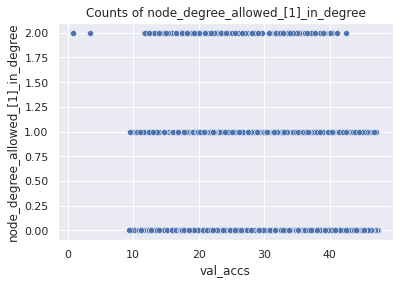

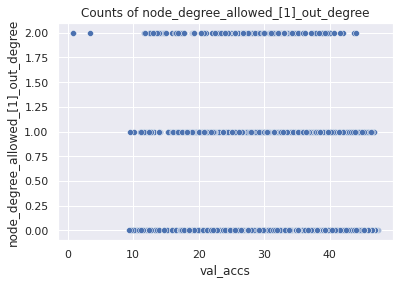

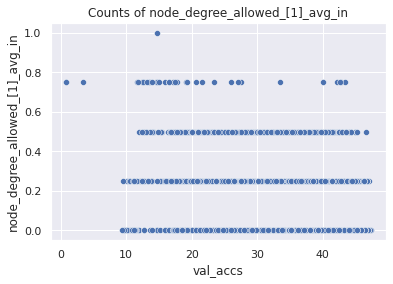

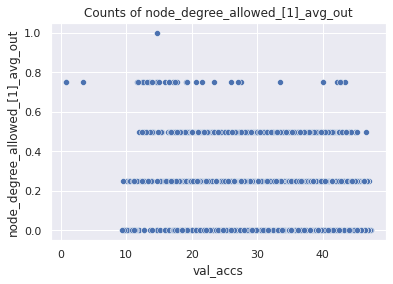

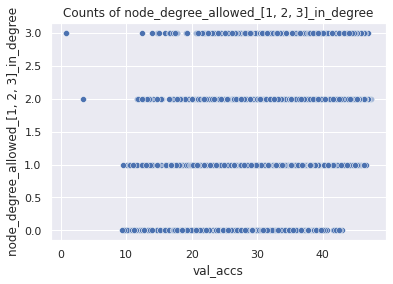

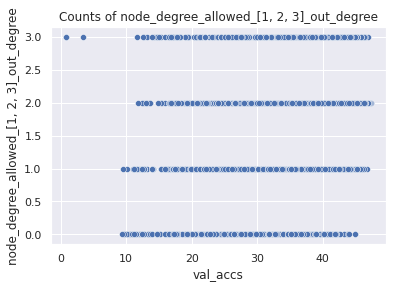

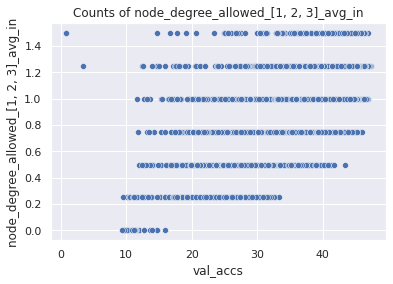

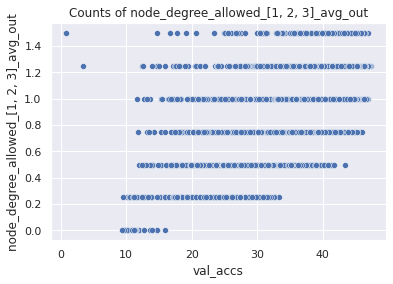

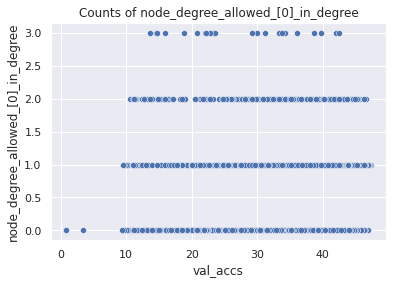

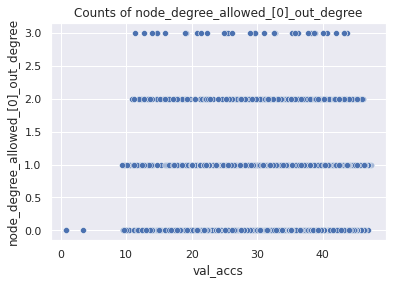

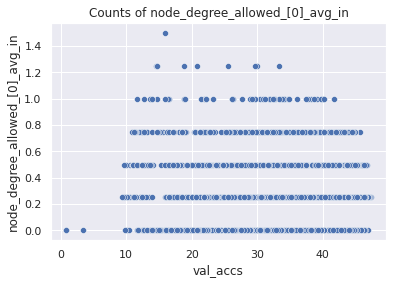

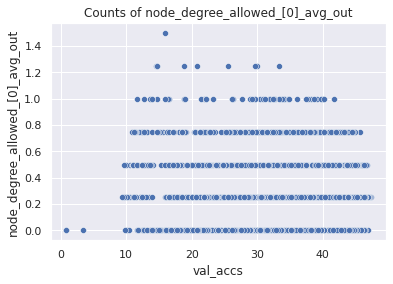

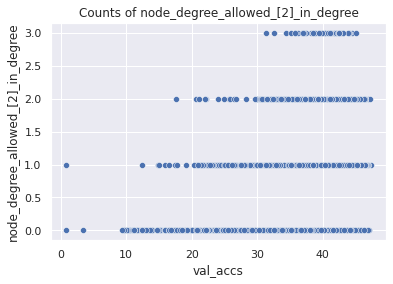

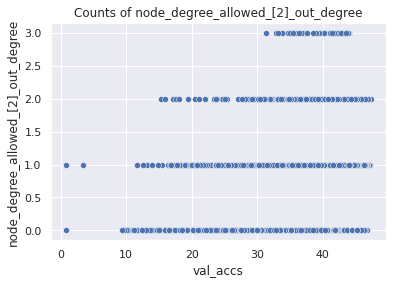

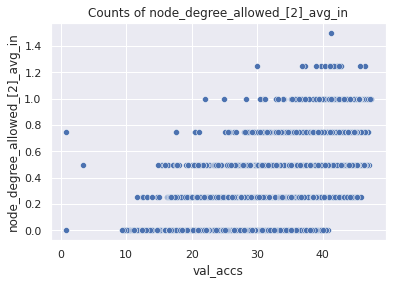

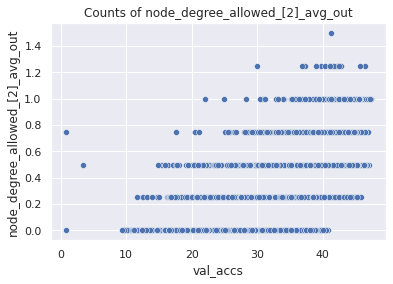

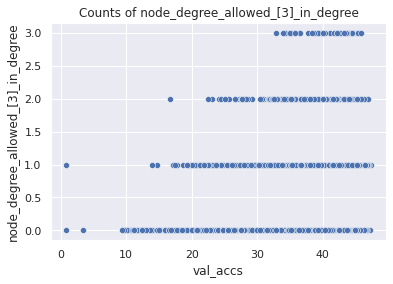

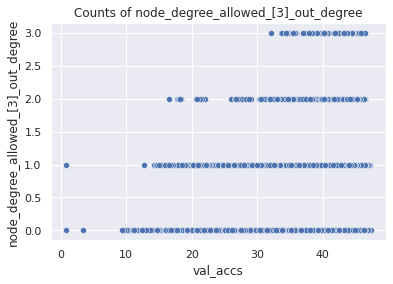

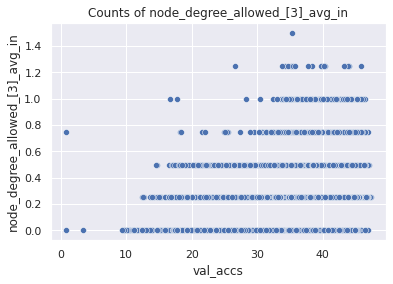

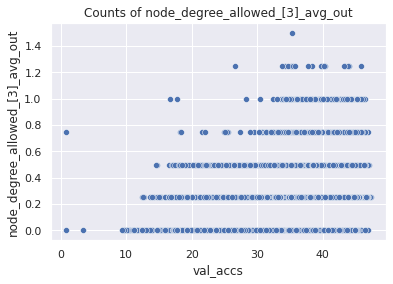

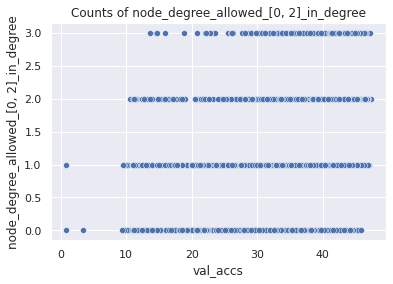

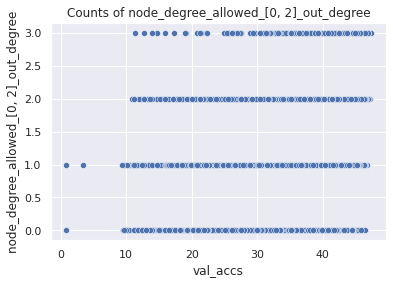

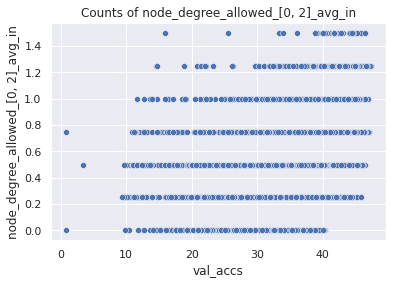

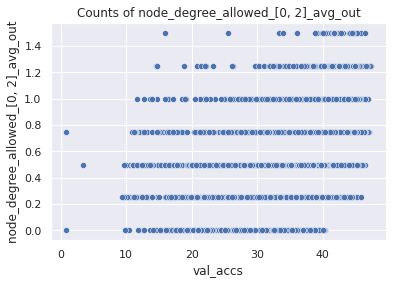

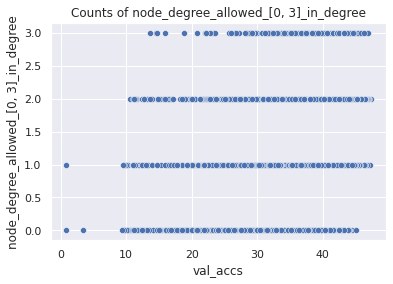

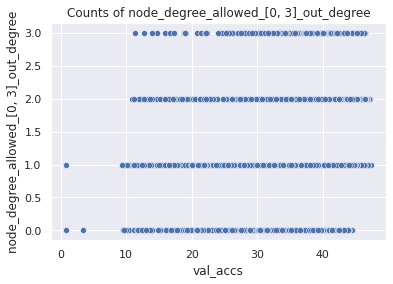

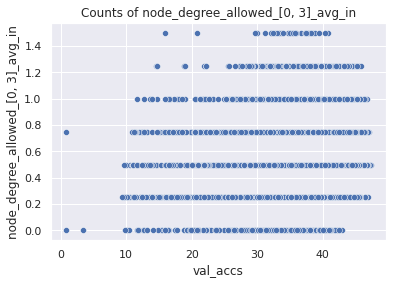

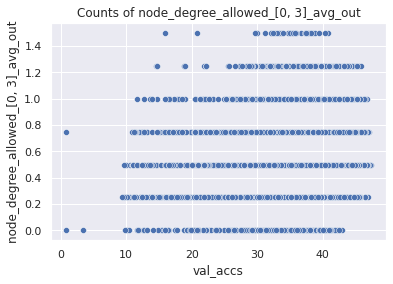

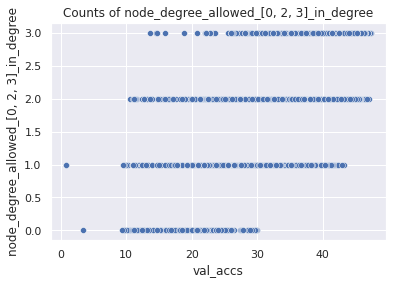

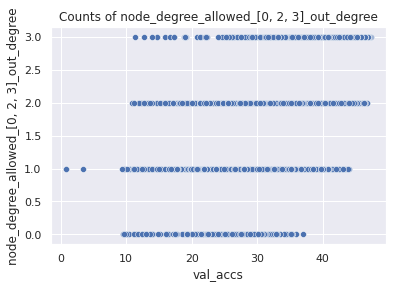

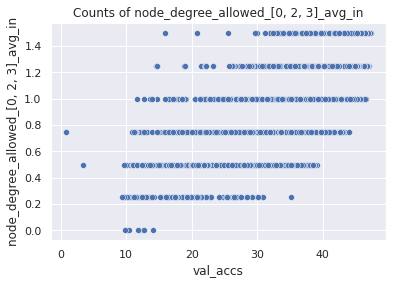

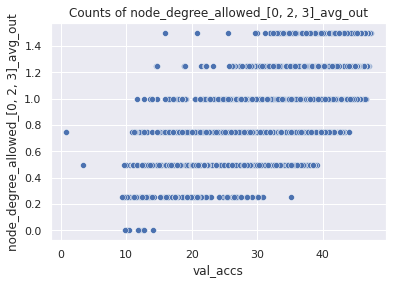

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plot_df = feature_dataset['node_degree'].copy()
plot_df['val_accs'] = data['val_accs']

import os
#os.mkdir('tmp')

for c in plot_df.columns:
    if c == 'val_accs':
        continue
    plt.figure()
    sns.scatterplot(data=plot_df, x='val_accs', y=c)
    plt.title(f"Counts of {c}")
    #plt.savefig(f'tmp/{c}.png')
    plt.show()

In [14]:
edges = list(edge_map.keys())

dataset_raw = {i: [n[1][e] for e in edges] for i, n in nets.items()}
dataset_raw[0]

[4, 0, 3, 1, 4, 3]

In [15]:
draw = [{'idx': i, **{f'op_{j}': v for j, v in enumerate(o)}} for i, o in dataset_raw.items()]
draw = pd.DataFrame(draw).set_index('idx')

In [16]:
proxy_cols = [c for c in data.columns if c not in ['random', 'rank', 'new_net', 'net']]


def get_dataset(feature_dfs, proxy_df, features, cols):
    feat_dfs = [feature_dfs[f] for f in features]
    prox_df = proxy_df[cols]

    res_data = pd.concat([*feat_dfs, prox_df], axis=1)

    y = proxy_df['val_accs'].loc[res_data.index]
    if 'val_accs' in res_data:
        res_data.drop(columns=['val_accs'], inplace=True)

    return res_data, y

features = ['op_count', 'min_path_len', 'max_op_on_path', 'node_degree']
full_data, full_y = get_dataset(feature_dataset, data, features, ['flops', 'params'])
print(full_data.shape)
full_data

(6144, 50)


,op_count_0,op_count_1,op_count_2,op_count_3,op_count_4,min_path_len_banned_[1],"min_path_len_banned_[0, 1]","min_path_len_banned_[0, 1, 4]","min_path_len_banned_[1, 4]",max_op_on_path_allowed_[0],...,"node_degree_allowed_[0, 3]_in_degree","node_degree_allowed_[0, 3]_out_degree","node_degree_allowed_[0, 3]_avg_in","node_degree_allowed_[0, 3]_avg_out","node_degree_allowed_[0, 2, 3]_in_degree","node_degree_allowed_[0, 2, 3]_out_degree","node_degree_allowed_[0, 2, 3]_avg_in","node_degree_allowed_[0, 2, 3]_avg_out",flops,params
0,1,1,0,2,2,1,1,1,1,2,...,2,2,0.75,0.75,2,2,0.75,0.75,4.820032,0.136456
1,2,0,2,1,1,1,2,2,1,2,...,1,2,0.75,0.75,2,3,1.25,1.25,21.316672,0.594536
3,2,1,2,1,0,1,1,1,1,2,...,2,1,0.75,0.75,3,3,1.25,1.25,20.994112,0.594536
7,0,1,0,4,1,1,1,1,1,0,...,1,3,1.00,1.00,1,3,1.00,1.00,6.678592,0.192456
8,0,1,2,3,0,1,1,1,1,0,...,1,1,0.75,0.75,2,3,1.25,1.25,23.175232,0.650536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15617,1,1,2,1,1,1,1,2,2,2,...,0,2,0.50,0.50,1,2,1.00,1.00,21.316672,0.594536
15618,2,0,2,1,1,1,1,1,1,2,...,1,2,0.75,0.75,3,3,1.25,1.25,21.316672,0.594536
15620,1,1,1,1,2,2,2,5,2,2,...,0,2,0.50,0.50,1,2,0.75,0.75,12.684352,0.351496
15622,0,0,2,3,1,1,1,1,1,0,...,2,1,0.75,0.75,3,2,1.25,1.25,23.497792,0.650536


In [17]:
import numpy as np
from scipy.stats import kendalltau, spearmanr
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


def get_splits(fd, fy, train_size=100, seed=42):
    return train_test_split(fd, fy, random_state=seed, train_size=train_size)

def eval_rf(trx, tex, tryy, tey, n_times=1, random_state=43):
    res = {'score': [], 'tau': [], 'corr': []}
    rfs = []
    for i in range(n_times):
        rf = RandomForestRegressor(random_state=random_state + i, n_estimators=100)
        rf.fit(trx, tryy)
        res['score'].append(rf.score(tex, tey))

        preds = rf.predict(tex)
        res['tau'].append(kendalltau(preds, tey)[0])
        res['corr'].append(spearmanr(preds, tey)[0])
        rfs.append(rf)

    return rfs, res

def print_means(res):
    print(", ".join([f"{k}: {np.mean(v)}" for k, v in res.items()]))

In [18]:
import numpy as np

features = ['op_count', 'min_path_len', 'max_op_on_path', 'node_degree']
seed = 44
for ts in [100, 200, 1000]:
    print(f"Train size {ts}")
    for prox in proxy_cols:
        for include_fp in [True, False]:
            if prox in ['flops', 'params']:
                continue
            print(prox, "" if include_fp else " no fp")

            plist = ['flops', 'params', prox] if include_fp else [prox]
            fd, fy = get_dataset(feature_dataset, data, features, plist)
            data_splits = get_splits(fd, fy, train_size=ts, seed=seed)

            _, res = eval_rf(*data_splits, n_times=5)
            print_means(res)
            print()

Train size 100
val_accs 
score: 0.7512829775390143, tau: 0.6970363776793916, corr: 0.8776543958853369

val_accs  no fp
score: 0.7360810494743131, tau: 0.6893816926090557, corr: 0.8699675312225723

epe_nas 
score: 0.7472854676112235, tau: 0.6952472838279461, corr: 0.8767828697535001

epe_nas  no fp
score: 0.7324450575344339, tau: 0.6877760326317837, corr: 0.8686774994082599

fisher 
score: 0.7659636224017637, tau: 0.702344343985691, corr: 0.8805688993254177

fisher  no fp
score: 0.7636676712532078, tau: 0.7065727082860999, corr: 0.8816568518214533

grad_norm 
score: 0.7699126822566068, tau: 0.7062463324025086, corr: 0.8834239847563914

grad_norm  no fp
score: 0.7655785867844825, tau: 0.7099630030684142, corr: 0.8842132848830853

grasp 
score: 0.7464000553481359, tau: 0.6950797032619008, corr: 0.8763060136371802

grasp  no fp
score: 0.7472903496255058, tau: 0.6986531361933259, corr: 0.8769258015496512

jacov 
score: 0.8138474588065833, tau: 0.7361350452721762, corr: 0.905466291279202

ja

In [99]:
ts = 100
seed = 44

all_proxies = False
prox_to_include = []
prox_to_include = ['jacov']
with_features = True

features = ['op_count', 'min_path_len', 'max_op_on_path', 'node_degree']
feat_list = features if with_features else []

# proxies to add to data
def_proxlist = ['params', 'flops'] if prox_to_include is None else ['params', 'flops', *prox_to_include]
prox_list = proxy_cols if all_proxies else def_proxlist

fd, fy = get_dataset(feature_dataset, data, feat_list, prox_list)
train_X, test_X, train_y, test_y = get_splits(fd, fy, train_size=ts, seed=seed)

rfs, res = eval_rf(train_X, test_X, train_y, test_y, n_times=5)
print_means(res)
rf_fitted = rfs[0]
preds = rf_fitted.predict(fd)
preds

score: 0.8136213389217364, tau: 0.7357204886659386, corr: 0.9052554185206878


array([35.86466663, 43.19166662, 42.63533331, ..., 35.83133328,
       44.07066663, 36.61866662])

In [100]:
trainpreds = rf_fitted.predict(train_X)

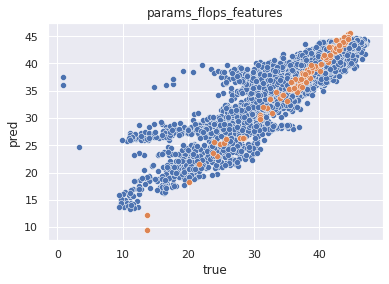

In [101]:
sns.scatterplot(data=pd.DataFrame({'pred': preds, 'true': fy}), x='true', y='pred')
sns.scatterplot(data=pd.DataFrame({'pred': trainpreds, 'true': train_y}), x='pred', y='true')
#plt.ylim(70, 95)

plt_name = f"{'all_proxies' if all_proxies else 'params_flops'}_{'features' if with_features else 'no_features'}"
plt.title(plt_name)
#plt.savefig(f"tmp/{plt_name}.png")
plt.show()

In [75]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_data = pca.fit_transform(fd)
pca_data

In [76]:
imps = rf_fitted.feature_importances_

pd.DataFrame({"importance": imps, "feat": fd.columns})

,importance,feat
0,0.001209,op_count_0
1,0.000589,op_count_1
2,0.001127,op_count_2
3,0.000825,op_count_3
4,0.005281,op_count_4
5,0.006013,min_path_len_banned_[1]
6,0.002441,"min_path_len_banned_[0, 1]"
7,0.001256,"min_path_len_banned_[0, 1, 4]"
8,0.371960,"min_path_len_banned_[1, 4]"
9,0.001597,max_op_on_path_allowed_[0]


In [ ]:
# IDEA ... sample different nets based on clustering (max distance between nets...)

In [27]:
pd.DataFrame({'pred': preds, 'true': y, 'net': data['net']})

,pred,true,net
0,33.802667,32.700000,"(4, 0, 3, 1, 4, 3)"
1,43.273667,44.233333,"(2, 4, 0, 0, 3, 2)"
3,43.515333,40.600000,"(0, 0, 2, 1, 2, 3)"
7,37.090333,37.100000,"(4, 1, 3, 3, 3, 3)"
8,43.614667,42.200000,"(3, 1, 2, 3, 2, 3)"
...,...,...,...
15617,40.057667,40.400000,"(2, 1, 4, 2, 3, 0)"
15618,39.843000,39.300000,"(3, 2, 2, 4, 0, 0)"
15620,35.865667,36.433333,"(4, 2, 1, 4, 3, 0)"
15622,40.240333,44.066667,"(2, 3, 3, 3, 2, 4)"


In [28]:
from scipy.stats import kendalltau, spearmanr

kendalltau(preds, dsy)[0], spearmanr(preds, dsy)[0]

(0.6811114913133042, 0.8547273907942495)

In [757]:
# TODO ruzny pocty siti
# where to sample... important
# TODO predikovat pres proxyny

# TODO vyplot predikci jen pres flops/params
# ... try that on transnb101

In [ ]:
#Next steps:

# TODO lepsi nazvy sloupecku, to str
# TODO fce co to spocita a da do df (myslim ty edge_path_op atd)
# TODO predikce - pres ruzny seedy, mozna crossval
# TODO porovnani s proxynama a bez, xgboost,...
# TODO tnb101

# TODO ruzny dalsi features...